# P2I-7 - MODELISATION NUMERIQUE POUR L’INGENIEUR 

## SUJET N°5 - Capteur MEMS résonant pour la mesure de masse de ultra-haute précision 
 
Professeur référent : Sebastien BAGUET 

Auteurs : BERTRAND Thomas – DOUMIT Marc - CHAN Taihani – HAUSERMANN Tristan

### Table des matières

- [I - Introduction](#i---introduction)  
- [II - Modélisation du problème](#ii---modelisation-du-probleme)  
  - [II.1 - Principe de Fonctionnement](#ii1---principe-de-fonctionnement)  
  - [II.2 - Modèle simplifié masse-ressort avec masse ajoutée](#ii2---modele-simplifie-masse-ressort-avec-masse-ajoutee)  
- [III - Modélisation du déplacement de la poutre via l’algorithme de Newmark](#iii---modelisation-du-deplacement-de-la-poutre-via-lalgorithme-de-newmark)  
- [IV - Méthode 1 : Décalage en fréquence](#iv---methode-1--decalage-en-frequence)  
  - [IV.1 - Tracé d’une courbe de réponse du résonateur sans masse ajoutée](#iv1---trace-dune-courbe-de-reponse-du-resonateur-sans-masse-ajoutee)  
  - [IV.2 - Modification du modèle et ajout d’une masse](#iv2---modification-du-modele-et-ajout-dune-masse)  
  - [IV.3 - Régression du décalage en fréquence en fonction de la masse ajoutée](#iv3---regression-du-decalage-en-frequence-en-fonction-de-la-masse-ajoutee)  
- [V - Méthode 2 : Saut en amplitude](#v---methode-2--saut-en-amplitude)  
  - [V.1 - Analyse du bassin d’attraction du système non-linéaire](#v1---analyse-du-bassin-dattraction-du-systeme-non-lineaire)  
  - [V.2 - Détection non-linéaire par saut d’amplitude](#v2---detection-non-lineaire-par-saut-damplitude)  
- [VI - Conclusion](#vi---conclusion)*

--> A METTRE A JOUR A LA FIN



## I - Introduction

L'amélioration des techniques industrielles permet aujourd'hui le développement de composants
technologiques de plus en plus petits. Ils ouvrent la porte à de nombreux domaines d'application tels que la
navigation, les télécommunications, les jeux vidéo, etc.

Les capteurs MEMS (Micro-Electro-Mechanical Systems) et leur version encore plus miniaturisée, les NEMS (Nano-Electro-Mechanical Systems), sont des systèmes capables de détecter de très faibles variations physiques ou chimiques grâce à leur structure à l’échelle micrométrique voire nanométrique Par exemple, on retrouve des MEMS dans les smartphones pour détecter les mouvements (accéléromètre), ou dans les airbags de voitures pour détecter les chocs.

**Dans ce projet, nous nous intéressons spécifiquement à la simulation d’un capteur MEMS de mesure
de masse d'ultra haute précision.**

Celui-ci fonctionne grâce à la résonance d'une nano-poutre soumise à une force électrostatique induite
par deux sources de tension : une continue et une alternative.

**Nous étudions l'effet de l'ajout d'une masse sur le comportement du système résonant et la
quantification de celle-ci en mesurant la variation de fréquence propre induite.**

PS : Les fonctions utilisées dans ce rapport se trouvent dans les fichiers Python joints.


## II - Modélisation du problème 

### II.1 - Principe de Fonctionnement

Le capteur étudié est basé sur une fine poutre conductrice (appelée « nano-poutre ») qui peut vibrer. On applique une tension continue ($V_{dc}$) qui la courbe légèrement, et une tension alternative ($V_{ac}$) pour la faire vibrer à sa fréquence naturelle. Lorsque l’on dépose une petite masse dessus, la fréquence de vibration change légèrement — un peu comme si l’on mettait un poids sur une corde de guitare tendue. Ce principe est comparable à celui d’une règle en plastique qu’on ferait vibrer en la fixant au bord d’une table : si on ajoute un petit poids au bout, elle vibre plus lentement.

**PHOTO/schéma**

À noter que : plus la taille du résonateur est petite, plus la fréquence fondamentale est grande (du MHz
au GHz) et plus la sensibilité du dispositif à une perturbation est grande. Une sensibilité élevée entraîne de
meilleures performances de mesure, telle qu'une plus grande gamme de mesures.

### II.2 - Modèle simplifié masse-ressort avec masse ajoutée 𝜹𝒎

Pour simplifier la modélisation et le traitement numérique du problème, on adopte un modèle de type masse-ressort à un degré de liberté, excité par les efforts électrostatiques générés par l’électrode.

<center>
<img src="./modele_simplifié_resonateur.JPG" alt width=500 heigth=550>

Figure 2 : Modèle simplifié masse-ressort avec masse ajoutée $\delta m$
</center>

L'équation du mouvement issue du Principe Fondamentale de la Dynamique sur $\vec{x}$ pour le modele simplifié est : 
$$ m \ddot{x} + c \dot{x} + k x = F_e(x,t)$$

$x$ étant le déplacement du bout de la poutre et $\dot{x}$, $\ddot{x}$ ses dérivées par rapport au temps t.

Avec :
- La force électrostatique non-linéaire est : $ F_e(x,t) = \frac{\varepsilon_0 A}{2} \cdot \frac{\left[ V_{dc} + V_{ac} \cos(\omega t) \right]^2}{(d - x)^2}$ , avec $\omega$ la pulsation d'excitation de la tension alternative
- $m = \rho A h$ : masse de la nano-poutre de masse volumique $\rho$ homogne
- $c$ et $k$ : coefficient d'amortissement et de raideur respectifs
    
    Et : 
    - $\epsilon_0 = 8.5*10^{-12} F.m^{-1} $ : permitivité diélectrique absolue du vide
    - $A=l*h $ : surface de la masse en vis-à-vis de l’électrode
    - $d$ : distance masse-électrode
    - $\omega$ : pulsation liée à l'excitation alternative
    - $V_{dc}$ : tension continue dans l'éléctrode
    - $V_{ac}$ : tension alternative dans l'éléctrode


**Cependant** :
Il est nécessaire d’adimensionner les variables $x$ et $\omega$ car, les ordres de grandeur étant significativement différents entre eux, nous pourrions obtenir des résultats soumis à des instabilités lors de la mise en place des schémas numériques.

On pose :
- $\tau = \omega_0t$ le temps adimensionné avec $\omega_0 = \sqrt{\frac{k}{m}}$ la pulsation propre du système
- $\Omega = \frac{\omega}{\omega_0}$ la pulsation d'excitation adimensionnée
- $y = \frac{x}{d}$ le déplacement sur $\vec{x}$ adimensionné
- $M = 1 + \frac{\delta m}{m}$ la masse adimensionnée du système {poutre + masse ajoutée}

En introduisant un développement limité à la force élétrostatique au coefficient $\frac{1}{(1-y)²}$, l'équation du mouvement du bout de la poutre devient :
$$\left(1 + \frac{\delta m}{m} \right)\ddot{y} + \xi \dot{y} + \left(1 - 2T V_{dc}^2 \right)y - \left(3T V_{dc}^2 \right)y^2 - \left(4T V_{dc}^2 \right)y^3 = T V_{dc}^2 + 2T V_{dc} V_{ac} \cos(\Omega \tau)$$

Avec : $T = \frac{\varepsilon_0 A}{2m \omega_0^2 d^3}$

Elle peut se mettre sous la forme:
$$M \ddot{y} + C \dot{y} + K y + f_{nl}(y) = p(\tau)$$

Et:
- $C = \xi = \frac{c}{mw_0} $ l'amortissement du mouvement
- $K = (1 - 2T V_{dc}^2) $ la raideur
- $f_{nl}(y) = - (3T V_{dc}^2)y^2 - (4T V_{dc}^2)y^3$ les efforts intérieurs
- $p(\tau) = T V_{dc}^2 + 2T V_{dc} V_{ac} \cos(\Omega \tau)$, l'excitation liée aux efforts extérieurs


Cette équation est non-linéaire. Ainsi, nous ne sommes pas en mesure de trouver une solution analytique.
C’est pourquoi nous utiliserons des schémas d’intégration numérique afin d’obtenir la solution numérique du mouvement.










In [1]:
# import des librairies additionnelles
import numpy as np
import matplotlib.pyplot as plt
from numpy import zeros
from IPython.display import display, clear_output


# Importation des fichiers
import newmark as nk
import newmark_masse_ajoutee as nk_ma
import newmark_saut as nk_s
import saut_final as sf
import trace_delta_m_f as dmf

%matplotlib widget
#%matplotlib notebook
#%matplotlib ipympl

## III - Modélisation du déplacement de la poutre via l’algorithme de Newmark

### III.1 - Tracé de l'évolution de l'extrémité de la poutre dans le temps
Dans un premier temps, nous travaillons sans masse ajoutée sur la poutre. Nous mettons en place
l’algorithme de Newmark afin de tracer l'évolution de la position de l’extrémité de la nano-poutre
en fonction du temps.

La courbe est obtenue pour une pulsation adimentionée d'excitation Ω donnée, avec deux conditions initiales sur la position et la
vitesse.



C:\Users\marcd\AppData\Local\Temp\ipykernel_5096\3969145518.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


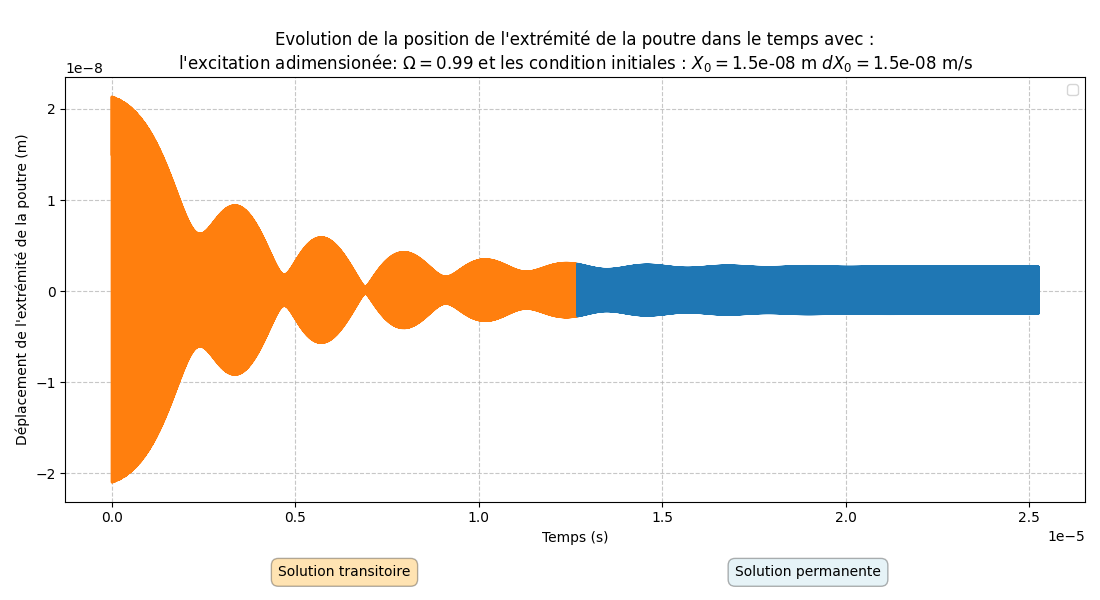

In [2]:
# Définition des paramètres 
T, Vdc, Vac, omega0, M, C, K, d = nk.init_params()

OMEGA = 0.99                 # Fréquence d'excitation de la tension alternative
Y0 = 0.5                     # Position adimensionnée initiale de la poutre
dY0 = 0.5                    # Vitesse adimensionnée initiale de la poutre

periode = 2 * np.pi / OMEGA  # Periode d'excitation de la tension alternative
nb_pts_per = 50              # Nombre de point par periode d'intégration temporelle
dt = periode / nb_pts_per    # Pas de temps pour l'intégration temporelle
nb_per = 2500                # Nombre de periode d'intégration temporelle
t_tot = nb_per * periode     # Temps total d'intégration temporelle
t_init = 0                   # Temps initial
NT = nb_per * nb_pts_per     # Nombre total de pas de temps

# Calcul de la réponse dynamique de la poutre avec la méthode de Newmark
tt, Yt, dYt = nk.Newmark(Y0, dY0, 0, dt,NT,omega0,T,Vdc,Vac,OMEGA,M,C,K)

# Détection du régime permanent (amplitude < 110% de l'amplitude max finale)
ampl_regime_perm = max(Yt[-3 * nb_pts_per:])  # amplitude max sur la derniere periode
seuil = ampl_regime_perm*1.1                  # seuil de 110% de l'amplitude max finale

# Trouver le premier indice id_perm à partir duquel tous les Yt < seuil (en remontant la courbe)
idx_perm = np.abs(len(Yt)-1)
while Yt[idx_perm] < seuil:
    idx_perm -= 1

# Affichage de la réponse dynamique de la poutre avec changement de couleur
fig, ax = plt.subplots(figsize = (11,6))
ax.plot(tt[:idx_perm]/omega0, Yt[:idx_perm]*d, color='tab:orange')
ax.plot(tt[idx_perm:]/omega0, Yt[idx_perm:]*d, color='tab:blue')

# Encadrés sous la courbe
ymin, ymax = ax.get_ylim()
ybox = ymin - 0.15*(ymax-ymin)

ax.text((tt[0]/omega0 + tt[idx_perm]/omega0)/2, ybox, "Solution transitoire", 
        ha='center', va='top', bbox=dict(facecolor='orange', alpha=0.3, boxstyle='round,pad=0.5'))
ax.text((tt[idx_perm]/omega0 + tt[-1]/omega0)/2, ybox, "Solution permanente", 
        ha='center', va='top', bbox=dict(facecolor='lightblue', alpha=0.3, boxstyle='round,pad=0.5'))

text = "Evolution de la position de l'extrémité de la poutre dans le temps avec :"+'\n'+r"l'excitation adimensionée: $\Omega =$"+f'{OMEGA}'+r' et les condition initiales : $X_0 = $'+f'{Y0*d} m '+r'$dX_0 =$'+f'{dY0*d} m/s'
ax.set_title(text)
ax.set_xlabel('Temps (s)')
ax.set_ylabel("Déplacement de l'extrémité de la poutre (m)")
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

### III.2 - Interprétation des données

Nous pouvons distinguer deux régimes dans l'étude de la variation de la position dans le temps. 

Un premier régime transitoire se stabilise vers un régime permanent harmonique très rapidement. 

**Remarque** Cette condition est nécessaire si l'on considère un capteur réel car les outils de mesures doivent être réactifs en cas de manipulation.

Cette solution numérique semble cohérente car elle reflète fidèlement le comportement de la nano-poutre. L'amplitude n'excède par exemple pas sa longueur d (ce qui serait physiquement impossible) et son déplacement tend progressivement vers une amplitude d'oscillation permanante qui dépend des 3 conditions initiales proposées.

## IV - Etude de l'évolution du régime permanent établi en fonction de la variation de la pulsation d'excitation adimensionnée $\Omega$



En faisant varier dans la cellule code précédente la pulsation adimentionnée $\Omega$, nous pouvons nous apercevoir que dans certains cas, l'amplitude obtenue en régime permanent est étonnament grande. Nous remarquons que des phénomènes de résonances ont lieu.

### IV.1 - Tracé d’une courbe de réponse du résonateur sans masse ajoutée

Afin d'étudier l'évolution du régime permanant établi en fonction de la variation de la pulsation d'excitation adimensionnée $\Omega$,
nous pouvons étudier la variation de l'amplitude en régime permanent en fonction d'Ω, avec le tracé de la courbe de réponse du capteur

Du fait de la non-linéarité de notre système, nous devons calculer les amplitudes en augmentant $\Omega$ et également en le
diminuant. 
Cela nous permet d'obtenir les deux réponses d’amplitude possibles dans la phase de non-linéarité.
Cette étude se fait entre deux bornes de ${\Omega}_{min}$ et ${\Omega}_{max}$ données. 

Afin d'optimiser le temps de calcul et la précision, nous pouvons raffiner le pas d'$\Omega$ uniquement sur le pic de la courbe de résonance.

Nous pouvons tracer la courbe de réponse suivante :

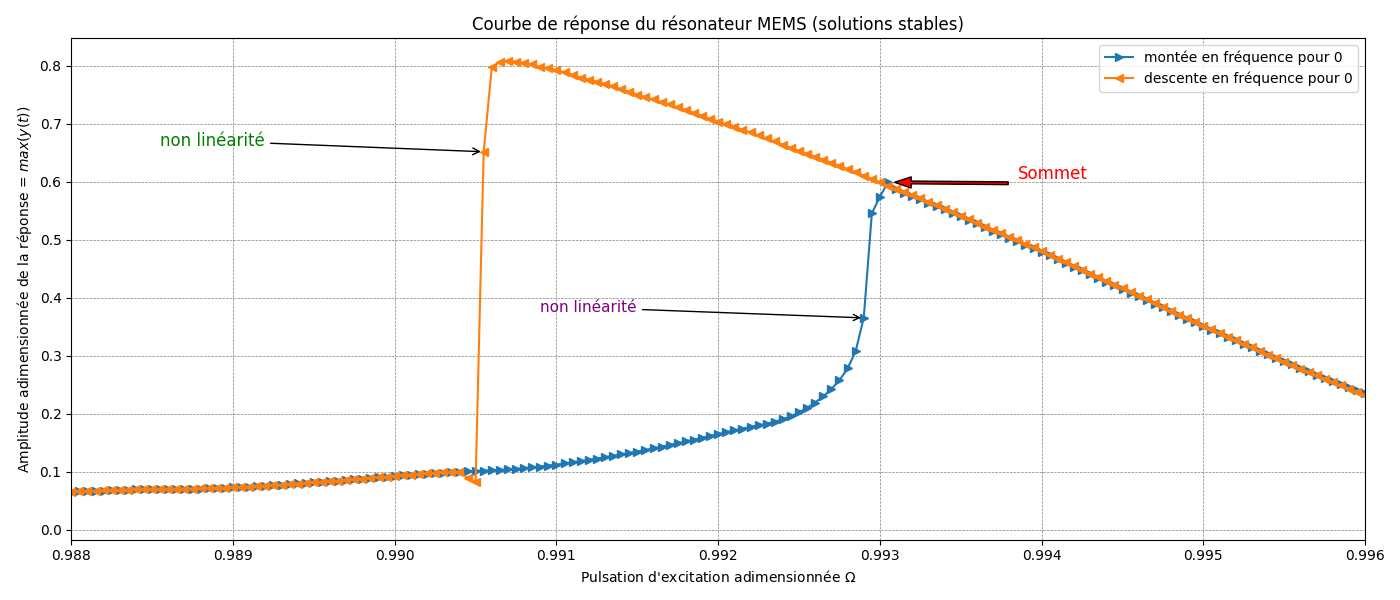

In [3]:
# courbe de reponse sans la courbe du prof + ttes les fleches qui montrent le sommet, les non lineairités, 
# en distinguant solution stables et instables (ds la courbe prof plus tard) + tracage dans le temps
# Paramètres
T, Vdc, Vac, omega0, M, C, K, d = nk.init_params()
dOMEGAinit = 0.00005
OMEGA_debut = 0.98
OMEGA_fin = 1
nb_pts_per = 50
nb_per = 500

# Calcul montée et descente
OME, AMPL = nk.compute_response_curve(T, Vdc, Vac, omega0, M, C, K, OMEGA_debut, OMEGA_fin, dOMEGAinit, nb_pts_per, nb_per)
OME2, AMPL2 = nk.compute_response_curve(T, Vdc, Vac, omega0, M, C, K, OMEGA_fin, OMEGA_debut, -dOMEGAinit, nb_pts_per, nb_per)

fig, ax = plt.subplots(figsize=(14,6))
nk.plot_response_curve(OME, AMPL, OME2, AMPL2, None, None, ax, tracer_data=False)

# Flèche sur le sommet
idx_max = np.argmax(AMPL)
OMEGA_max = OME[idx_max][0]
AMPL_max = AMPL[idx_max][0]
ax.annotate('Sommet', xy=(OMEGA_max, AMPL_max), xytext=(OMEGA_max+0.0008, AMPL_max+0.005),
            arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8), color='red', fontsize=12)

# Flèche zone non linéaire (exemple : là où la courbe penche)
idx_nl = np.argmax(AMPL > (AMPL.max()*0.7))
ax.annotate('non linéarité', xy=(OME[idx_nl-1][0], AMPL[idx_nl-1][0]), xytext=(OME[idx_nl-1][0]-0.002, AMPL[idx_nl-1][0]+0.01),
            arrowprops=dict(facecolor='purple', arrowstyle='->'), color='purple', fontsize=11)

diff_desc = np.diff(AMPL2.flatten())
idx_saut_desc = np.argmin(diff_desc)
OMEGA_saut_desc = OME2[idx_saut_desc][0]
AMPL_saut_desc = AMPL2[idx_saut_desc][0]
ax.annotate('non linéarité', xy=(OMEGA_saut_desc, AMPL_saut_desc), 
            xytext=(OMEGA_saut_desc-0.002, AMPL_saut_desc+0.01),
            arrowprops=dict(facecolor='green', arrowstyle='->'), color='green', fontsize=12)

ax.set_xlabel(r"Pulsation d'excitation adimensionnée $\Omega$")
ax.set_title("Courbe de réponse du résonateur MEMS (solutions stables)")
plt.tight_layout()
plt.show()

Nous pouvons comparer nos données avec les données fournies par notre enseignant référent en les superposant dans le même graphe que notre courbe de réponse.

A noter que via nos methodes de résolution, différentes que celles utilisées pour avoir ces données, nous ne pouvons pas obtenir les solutions instables.

In [4]:
OMEGA_data, AMPL_data = nk.recuperer_courbe_data('Courbes de réponse/courbe_reference.txt')
ax.plot(OMEGA_data, AMPL_data, color='green', marker='o', label='Courbe de référence')
print('\n** Figure précédente mise à jour ! **\n')


** Figure précédente mise à jour ! **



Notre courbe de réponse se superpose bien sur celle de référence, nous pouvons donc nous satisfaire de cette première approche. Par ailleurs, les non-linéarités sont alors visibles via le pic de résonance penché.

## V - Méthode 1 : Mesure du décalage en fréquence



### IV.2 - Modification du modèle et ajout d’une masse $\delta m$

Maintenant que le modèle fonctionne sans masse ajoutée, nous pouvons simuler l’ajout d’une petite masse
sur la poutre en modifiant la valeur de la masse adimensionnée 𝑀. 

En utilisant le même algorithme que celui
des étapes précédentes, nous pouvons tracer l'évolution de l'amplitude dans le temps (Newmark) et enfin la courbe de réponse du capteur numérique.
Afin de pouvoir comparer le comportement du capteur avec et sans masse ajoutée $\delta m$, nous pouvons superposer les courbes de réponse sur un même graphique.
Nous observons :

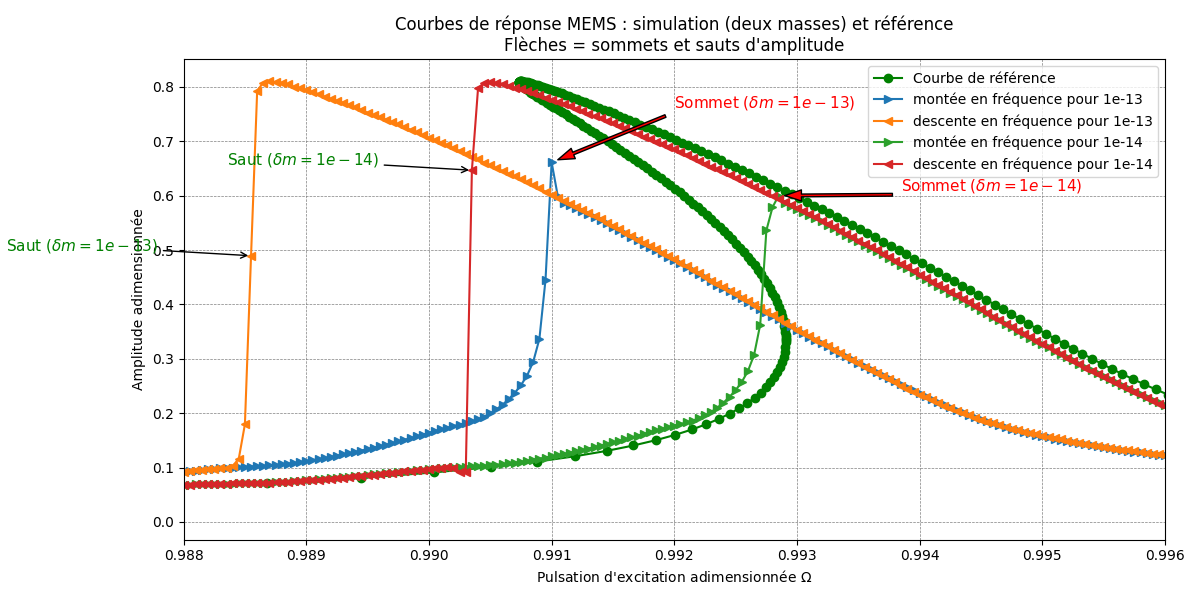

In [5]:
fig, ax = plt.subplots(figsize = (12,6))

dOMEGAinit = 0.00005
OMEGA_debut = 0.98
OMEGA_fin = 1

delta_m = 1e-13          # Valeur de delta_m pour la courbe de réponse (a modifier)

OMEGA_MAX, OME, AMPL, OME2, AMPL2 = nk_ma.courbe_reponse_delta_m(OMEGA_debut, OMEGA_fin, dOMEGAinit, deltam=1e-13, montee=True, data = True)
# Flèche sommet (delta_m = 1e-13)
idx_max = np.argmax(AMPL)
OMEGA_max = OME[idx_max][0]
AMPL_max = AMPL[idx_max][0]
ax.annotate(r'Sommet ($\delta m=1e-13$)', xy=(OMEGA_max, AMPL_max),
            xytext=(OMEGA_max+0.001, AMPL_max+0.1),
            arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8),
            color='red', fontsize=11)

# Flèche saut descente (delta_m = 1e-13)
diff_desc = np.diff(AMPL2.flatten())
idx_saut_desc = np.argmin(diff_desc)
OMEGA_saut_desc = OME2[idx_saut_desc][0]
AMPL_saut_desc = AMPL2[idx_saut_desc][0]
ax.annotate(r'Saut ($\delta m=1e-13$)', xy=(OMEGA_saut_desc, AMPL_saut_desc),
            xytext=(OMEGA_saut_desc-0.002, AMPL_saut_desc+0.01),
            arrowprops=dict(facecolor='green', arrowstyle='->'),
            color='green', fontsize=11)
nk.plot_response_curve(OME, AMPL, OME2, AMPL2, OMEGA_data, AMPL_data, ax, deltam=1e-13, tracer_data=True)

OMEGA_MAX, OME, AMPL, OME2, AMPL2 = nk_ma.courbe_reponse_delta_m(OMEGA_debut, OMEGA_fin, dOMEGAinit, deltam=1e-14, montee=True, data = True)
# Flèche sommet (delta_m = 1e-14)
idx_max2 = np.argmax(AMPL)
OMEGA_max2 = OME[idx_max2][0]
AMPL_max2 = AMPL[idx_max2][0]
ax.annotate(r'Sommet ($\delta m=1e-14$)', xy=(OMEGA_max2, AMPL_max2),
            xytext=(OMEGA_max2+0.001, AMPL_max2+0.01),
            arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8),
            color='red', fontsize=11)

# Flèche saut descente (delta_m = 1e-14)
diff_desc2 = np.diff(AMPL2.flatten())
idx_saut_desc2 = np.argmin(diff_desc2)
OMEGA_saut_desc2 = OME2[idx_saut_desc2][0]
AMPL_saut_desc2 = AMPL2[idx_saut_desc2][0]
ax.annotate(r'Saut ($\delta m=1e-14$)', xy=(OMEGA_saut_desc2, AMPL_saut_desc2),
            xytext=(OMEGA_saut_desc2-0.002, AMPL_saut_desc2+0.01),
            arrowprops=dict(facecolor='green', arrowstyle='->'),
            color='green', fontsize=11)


nk.plot_response_curve(OME, AMPL, OME2, AMPL2, OMEGA_data, AMPL_data, ax, deltam=1e-14)

ax.set_xlabel(r"Pulsation d'excitation adimensionnée $\Omega$")
ax.set_ylabel("Amplitude adimensionnée")
ax.set_title("Courbes de réponse MEMS : simulation (deux masses) et référence\nFlèches = sommets et sauts d'amplitude")
ax.legend()
plt.tight_layout()
plt.show()



En testant l'ajout de plusieurs masses, nous pouvons observer que plus la masse ajoutée est grande, plus la courbe se translate sur l'axe des abscisses négativement. L'ajout d'une masse crée un décalage de la courbe de réponse négatif sur les abscisses par rapport à la réponse de résonnance sans masse ajoutée.

**On peut alors se demander comment évolue la différence de pulsation (et donc la différence de fréquence fondamentale de flexion) lorque l'on ajoute une masse $\delta m$ à l'extremité de la nano-poutre.**

### V.3 - Régression du décalage en fréquence d'oscillation en fonction de la masse ajoutée

Nous allons donc chercher à mesurer le décalage en pulsation adimensionné des deux courbes de réponses. Pour cela nous devons mesurer la différence de pulsation adimensionné entre deux points particuliers de localisation sur la courbe identique (voir ci-dessus).

Nous avons choisi le sommet du pic de résonance afin d’avoir un point caractéristique pour chaque courbe simple à identifier. Ce point particulier permet un répétabilité de mesure aisée quelque soit l'ajout de masse, d'autant plus que le raffinage sur ce tronçon permet d'identifier la pulsation de résonance maximum avec précision.

Pour une liste de masse, nous pouvons alors chercher à tracer l'évolution de la différence de fréquence d'oscillation réelle $\Delta f$ par rapport à la masse ajoutée $\delta m$.

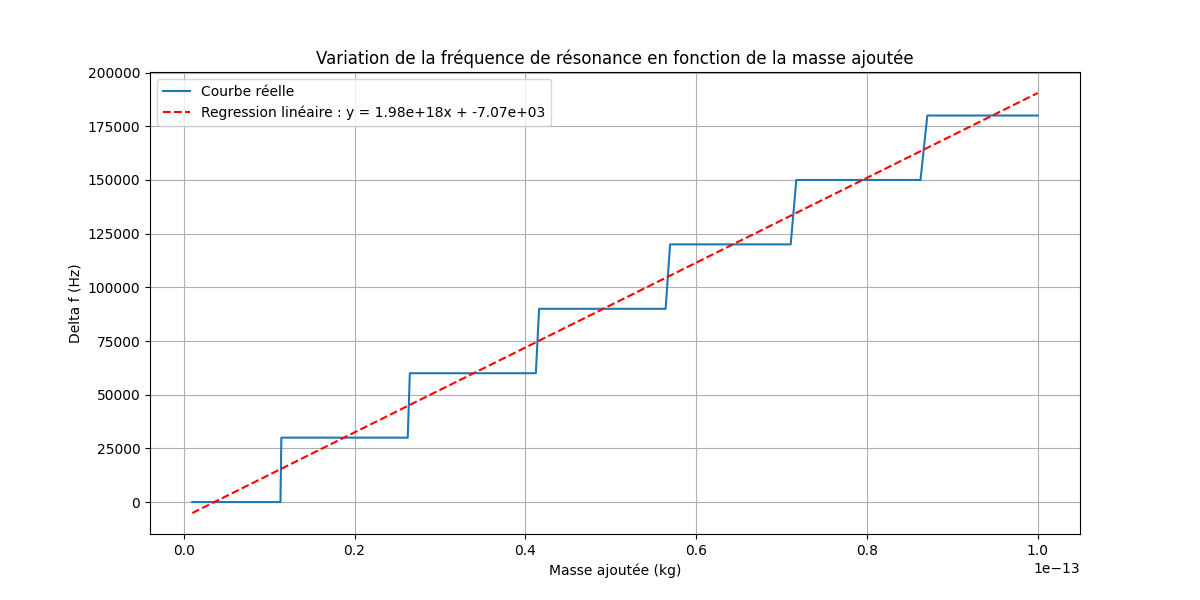

In [ ]:
# Paramètres
liste_delta_m = np.logspace(-15, -13, 100, base=10)
OMEGA_debut = 0.985
OMEGA_fin = 1
dOMEGA = 0.0003
f0 = 100e6

# Tracé
fig, ax = plt.subplots(figsize=(12,6))
dmf.tracer_delta_m_f(liste_delta_m, OMEGA_debut, OMEGA_fin, dOMEGA, f0)
plt.xlabel('Masse ajoutée (kg)')
plt.ylabel('Delta f (Hz)')
plt.title('Variation de la fréquence de résonance en fonction de la masse ajoutée')
plt.legend()
plt.grid()
plt.show()
#TRACER DEUX FIGURES DIFFERENTES POUR LES MASSES AJOUTEES ET LE DELTA F EN LINEAIRE 
# FAIRE GAFFE A BIEN DIFFERENCIER FREQUENCE ET FREQUENCE ADIMENSIONNEE !

Nous pouvons nous rendre compte que l'évolution de la  différence de fréquence d'oscillation en fonction de la masse ajoutée est linéaire. 

A noter : En échelle semi-log nous pouvons observer une variation exponentielle (cohérente avec la variation linéaire en echelle linéaire) tout en pouvant observer sur l'axe des abscisses la valeur des masses ajoutées.

In [12]:
# TRACER UNE DEUXIEMME COURBE EN SEMI-LOG A COTE (DROITE) DE LA FIGURE PRECEDENTE (POUR VOIR QUE 1e-15 CA BLOQUE) 
# + AJOUTER LA REGRESSION LINEAIRE ET L4EQUATION DE LA COURBE
# + la retourner dans le txt suivant
plt.xscale('log')
print('\n** Figure précédente mise à jour ! **\n')


** Figure précédente mise à jour ! **



Nous pouvons donc obtenir l'équation de la régression linéaire : $ \Delta f = 1.99.10^{18} \Delta m - 7,35.10^{3}$

Comme nous pouvons le voir, celle-ci n'est valable que jusqu'à une certaine précision de l'ordre de $\delta m_{min} \approx 10^{-15} kg$, au dela de laquelle les erreurs numériques prennent le dessus et rendent les mesures bruitées et insignifiantes.

À l'aide de la régression linéaire obtenue, nous pouvons en déduire la masse minimale détectable par le capteur de masse.

Techniquement parlant, si nous arrivons avec un autre capteur à mesurer la fréquence d'oscillation de la nano-poutre d'un réel capteur avec les mêmes caractéristiques que celui de la simulation, nous pouvons réussir à l'aide de la régression obtenue, remonter jusqu'à la masse $\delta m$ que nous avons ajoutée.

**Cependant, un $\delta m_{min} \approx 10^{-15} kg$ correspond à la masse de certaines bactéries ou de levures, mais pourrions nous mesurer une masse encore plus faible, comme celle d'une cellule virale, en implémentant une autre methodologie de résolution ?**

## VI - Méthode 2 : Balayage continu de la pulsation adimentionnée d'excitation de la tension alternative


### VI.1 - Théorie de la méthode 2

Nous cherchons donc une autre méthode pour détecter un ajout de masse qui serait encore plus précis.

Dans ces conditions, une technique brevetée par notre enseignant référent consiste à modifier la pulsation d'excitation de la tension alternative $\omega $ en continue. Cette modification en continue permet de faire varier dans le temps l'ancien $\Omega$, remplacé par la suite par $\theta$, sous la forme d'un balayage entre deux pulsations adimentionnées $\Omega_{min}$ et $\Omega_{max}$ fixes. Ainsi, nous mettons en place un balayage en continu des pulsations, ce qui permet de relever la "hauteur" du saut de la solution basse à la solution haute d'une courbe de réponse. Pour ce faire, nous modifions l'excitation de la poutre, maintenant variable au cours du temps : 

$$\theta(\tau) = \Omega_c t + \frac{\Delta \Omega}{\Omega_{bal}} cos(\Omega_{bal} \tau) $$

avec :
- $\Omega_c = \frac{\Omega_{max} + \Omega_{min}}{2}$, la pulsation adimentionnée moyenne
- $\Delta \Omega = \frac{\Omega_{max} - \Omega_{min}}{2}$, l'équart entre $\Omega_c$ et $\Omega_{max/min}$
- $\Omega_{bal}$ la pulsation liée à la fréquence de balayage

La nano-poutre est donc toujours soumise à une excitation extérieure, qui dépend désormais de $\theta$ :
- $p(\theta) = T V_{dc}^2 + 2T V_{dc} V_{ac} \cos(\theta(\tau))$

Celle-ci varie sous la forme d'un signal à modulation de phase, ou plus précisément un cosinus à phase modulée par $\theta$ (elle pourrait être développable en série de Bessel)

**Comment détecte-t-on un saut ?**

- Dans un premier temps, sans masse ajoutée, nous pouvons tracer l'évolution de l'extremité de la nano-poutre dans le temps avec le balayage en fréquence.

En choisissant des borne de $\Omega_{max}$ et $\Omega_{min}$ adaptées, nous pouvons donc chercher à faire en sorte que les amplitudes restent minimales afin que lorsque nous ajouterons une masse ajoutée, de même manière que la courbe de réponse se décale vers les abscisses négatives.

En réglant optimalement $\Omega_{min}$, nous pouvons faire en sorte que quelque soit les conditions initiales, si l'on sort de la zone de bistabilité vers les abscisses négatives (sur la gauche), l'amplitude "retombe" sur les amplitudes de montée en fréquence de la courbe de réponse.

Il reste donc à régler optimalement $\Omega_{max}$. Afin de mesurer un saut d'amplitude, nous pouvons régler $\Omega_{max}$ à la limite de saut d'amplitude pour aucune masse ajoutée. A cet $\Omega_{max}$, lorsque l'on ajoutera une masse $\delta m$, la courbe de réponse se translatera vers les abscisses negatives et l'amplitude "sautera" vers les solutions d'amplitude haute. 
Si l'on trace l'évolution de l'amplitude du résonateur dans le temps, lors de l'ajout d'une masse, un saut apparaitra!

- Dans un second temps, nous pouvons optimiser le transitoire lors de la lancée de Newmark en prenant des conditions initiales optimales. Celle-ci peuvent être déterminées à l'aide d'un bassin d'attraction

- Enfin, la précision de la masse minimale détectable dépend de la précision du $\Omega_{max}$ donné, au plus proche de la pulsation adimentionnée de saut pour la nano-poutre sans masse ajoutée.

### VI.1 - Tracé de l'évolution de l'extrémité de la poutre dans le temps sans masse ajoutée

In [28]:
#TRACER JUSTE POUR LA SANS MASSE AJOUTE +  donner des details sur tout les Omega etc choisit ! 
# Bien preciser pas adimentionner et multiplier par d !

Nous pouvons donc observer 
A noter : Le schéma de Newmark converge alors vers une solution périodique de période $\frac{2 \pi}{\Omega_c}$, dans le cas où il converge.

### V.1 - Analyse du bassin d’attraction du système non-linéaire

Notre système étant non linéaire, il peut admettre deux solutions différentes pour une même pulsation. C’est pourquoi utilisons le bassin d'attraction afin d'étudier vers laquelle de ces solutions l’équation évolue en fonction des conditions initiales, sans aucune masse ajoutée. 

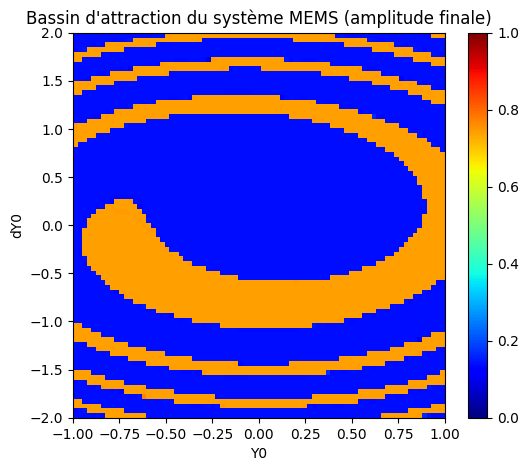

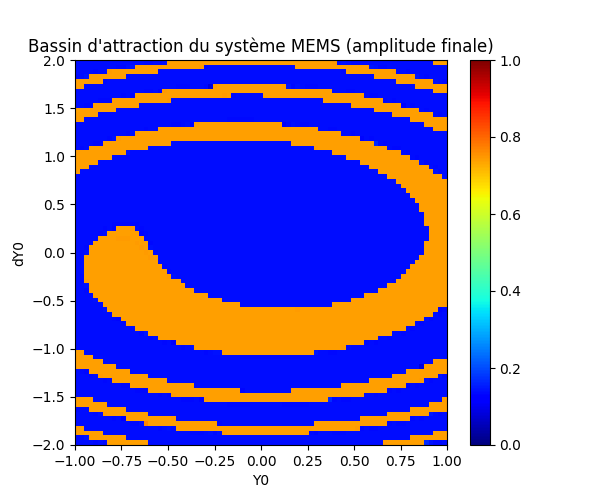

In [ ]:
# Visualisation animée du bassin d'attraction 

# Initialisation des paramètres physiques et numériques
T, Vdc, Vac, omega0, M, C, K, d = nk.init_params(1e-13)
OMEGA = 0.99                                            
nb_pts_per = 60                                         
nb_per = 2500                                          
periode = 2 * np.pi / OMEGA                              
dt = periode / nb_pts_per                              
t_init = 0                                              
NT = nb_per * nb_pts_per                               

# Définition de la grille des conditions initiales
pasY = 0.025                                             
pasdY = 0.05                                             
Y0 = np.arange(-1, 1 + pasY, pasY)                      
dY0 = np.arange(-2, 2 + pasdY, pasdY)                    
AMPL = np.zeros((len(dY0), len(Y0)))                

# Création de la figure et de l'axe pour l'animation
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_xlabel('Y0 adimensionné')
ax.set_ylabel('dY0 adimensionné')
im = ax.imshow(AMPL, interpolation='none', aspect='auto',
               extent=[-1, 1, -2, 2], vmin=0, vmax=1, cmap='jet')
fig.colorbar(im, ax=ax)
ax.set_title("Bassin d'attraction du système MEMS (amplitude finale)")

# Boucle sur la grille des conditions initiales
for i in range(len(Y0)):
    for j in range(len(dY0)):
        # Simulation de la dynamique pour chaque couple (Y0, dY0)
        tt, Yt, dYt = nk.Newmark(Y0[i], dY0[j], t_init, dt, NT, omega0, T, Vdc, Vac, OMEGA, M, C, K)
        # Extraction de l'amplitude maximale sur les 2 dernières périodes (régime permanent)
        AMPL[j, i] = np.max(Yt[-2 * nb_pts_per:])
        im.set_data(AMPL)
    # Mise à jour dynamique de la figure à chaque colonne de Y0
    clear_output(wait=True)
    display(fig)
    plt.pause(0.01)  # Pause pour laisser le temps à l'affichage


Le bassin d'attraction nous permet ainsi de choisir des conditions initiales pour partir de la solution basse de la courbe de réponse (zones en bleue sur le bassin).

A la lecture du bassin, nous choisissons donc : 
- $Y0 = 0.3$
- $dY0 = 0.3$

### V.2 - Détection non-linéaire par saut d’amplitude

expliquer pourquoi on a masse plus petite 

## VI - Conclusion